In [5]:
%load_ext autoreload
%autoreload 2
import datahelper

import numpy as np
import tensorflow as tf
from tensorflow import keras as kr
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import cv2
import matplotlib.pyplot as plt
from IPython.display import Video

np.random.seed(4212)

In [6]:
DATA_PATH = "/home/mattr/Desktop/udacity/CarND-Behavioral-Cloning-P3/training/data/"
DRIVING_FOLDERS = {'easy': 'drivingData', 'hard': 'drivingDataHard', 'john': 'johnsDrivingData'}

# Data Pre-Processing

## Step 1: Load data and clean csv
- I recorded some data on my laptop but I'm training the model on my own dl server so I have to change the path names.
- Next I'm going to split the data into test and training sets
## Step 2: Data Exploration!!
- I will load some images from the training set and decide on image processing steps
- Find distributions of steering angle, throttle, break, and speed
## Step 3: Make a data pipeline
- Once I have determined the best pre-processing steps I will implement a pipeline to pre-process all the data


## Step 1

In [7]:
easy_driving_df = datahelper.process.preprocessing.import_driving_log(DATA_PATH+DRIVING_FOLDERS['easy']+'/driving_log.csv', DATA_PATH)
hard_driving_df = datahelper.process.preprocessing.import_driving_log(DATA_PATH+DRIVING_FOLDERS['hard']+'/driving_log.csv', DATA_PATH)
john_driving_df = datahelper.process.preprocessing.import_driving_log(DATA_PATH+DRIVING_FOLDERS['john']+'/driving_log.csv', DATA_PATH)
easy_driving_df.head()

,center_img,left_img,right_img,steering_angle,throttle,brake,speed
0,/home/mattr/Desktop/udacity/CarND-Behavioral-C...,/home/mattr/Desktop/udacity/CarND-Behavioral-C...,/home/mattr/Desktop/udacity/CarND-Behavioral-C...,0.000000,0.0,0.0,25.32430
1,/home/mattr/Desktop/udacity/CarND-Behavioral-C...,/home/mattr/Desktop/udacity/CarND-Behavioral-C...,/home/mattr/Desktop/udacity/CarND-Behavioral-C...,0.000000,0.0,0.0,25.17072
2,/home/mattr/Desktop/udacity/CarND-Behavioral-C...,/home/mattr/Desktop/udacity/CarND-Behavioral-C...,/home/mattr/Desktop/udacity/CarND-Behavioral-C...,0.000000,0.0,0.0,24.96740
3,/home/mattr/Desktop/udacity/CarND-Behavioral-C...,/home/mattr/Desktop/udacity/CarND-Behavioral-C...,/home/mattr/Desktop/udacity/CarND-Behavioral-C...,0.000000,0.0,0.0,24.81597
4,/home/mattr/Desktop/udacity/CarND-Behavioral-C...,/home/mattr/Desktop/udacity/CarND-Behavioral-C...,/home/mattr/Desktop/udacity/CarND-Behavioral-C...,-0.112782,0.0,0.0,24.66253


In [8]:
easy_driving_df['center_img'][0]

'/home/mattr/Desktop/udacity/CarND-Behavioral-Cloning-P3/training/data/drivingData/IMG/center_2021_09_29_12_10_46_429.jpg'

In [9]:
easy_records = [datahelper.datasets.DrivingRecord(record) for record in datahelper.process.preprocessing.find_records(easy_driving_df)]
hard_records = [datahelper.datasets.DrivingRecord(record) for record in datahelper.process.preprocessing.find_records(hard_driving_df)]
john_records = [datahelper.datasets.DrivingRecord(record) for record in datahelper.process.preprocessing.find_records(john_driving_df)]

In [10]:
print(f"Number of easy records: {len(easy_records)}\nNumber of hard records: {len(hard_records)}\nNumber of john records: {len(john_records)}")

Number of easy records: 4
Number of hard records: 5
Number of john records: 9


In [11]:
s = 0
for record in easy_records:
    s += len(record)
print("Average length of easy_records", s/4)
s = 0
for record in hard_records:
    s += len(record)
print("Average length of hard_records", s/5)
s = 0
for record in john_records:
    s += len(record)
print("Average length of john_records", round(s/9, 1))

Average length of easy_records 981.5
Average length of hard_records 1734.2
Average length of john_records 812.4


In [12]:
for index, record in enumerate(easy_records):
    record_length = len(record)
    ave_speed = sum([record.get_attribute(i, 'speed') for i in range(record_length)])
    ave_speed /= record_length
    print(f"Average speed of easy record {index} =", ave_speed)

Average speed of easy record 0 = 29.93008383971288
Average speed of easy record 1 = 15.111851774612253
Average speed of easy record 2 = 23.34869946835444
Average speed of easy record 3 = 15.327890382206723


In [13]:
for index, record in enumerate(hard_records):
    record_length = len(record)
    ave_speed = sum([record.get_attribute(i, 'speed') for i in range(record_length)])
    ave_speed /= record_length
    print(f"Average speed of hard record {index} =", ave_speed)

Average speed of hard record 0 = 18.15653915810563
Average speed of hard record 1 = 21.325574233684627
Average speed of hard record 2 = 12.01282012592593
Average speed of hard record 3 = 11.536492432081914
Average speed of hard record 4 = 13.686280197900263


In [14]:
for index, record in enumerate(john_records):
    record_length = len(record)
    ave_speed = sum([record.get_attribute(i, 'speed') for i in range(record_length)])
    ave_speed /= record_length
    print(f"Average speed of john record {index} =", ave_speed)

Average speed of john record 0 = 18.46285795635445
Average speed of john record 1 = 25.274414103228565
Average speed of john record 2 = 18.534745673547665
Average speed of john record 3 = 29.81729226015545
Average speed of john record 4 = 12.926317482499453
Average speed of john record 5 = 22.476285131699218
Average speed of john record 6 = 24.99603134644568
Average speed of john record 7 = 25.182528864181908
Average speed of john record 8 = 23.072508095906592


In [29]:
# Usually we use `%matplotlib inline`. However we need `notebook` for the anim to render in the notebook.
%matplotlib notebook


import matplotlib.pyplot as plt

import matplotlib.animation as animation


fps = 30
nSeconds = .07 * len(easy_records[1])
snapshots = [ easy_records[1][i][0][:, :, 3:6] for i in range( len(easy_records[1]) ) ]

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure( figsize=(10,5) )

a = snapshots[0]
im = plt.imshow(a, interpolation='none', aspect='auto', vmin=0, vmax=1)

def animate_func(i):
    if i % fps == 0:
        print( '.', end ='' )

    im.set_array(snapshots[i])
    return [im]

anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = len(easy_records[1]),
                               interval =70, # in ms
                               )

anim.save('test_anim.mp4', fps=fps, extra_args=['-vcodec', 'libx264'])
del snapshots
print('Done!')

<IPython.core.display.Javascript object>

..........Done!


.................................................................................................................

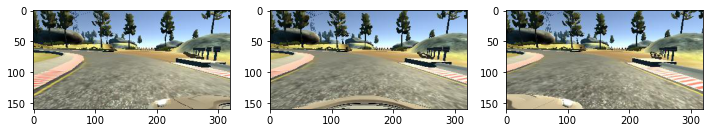

In [46]:
datahelper.plots.animate_record(easy_records[0])

In [47]:
Video("test_anim.mp4")